In [1]:
%load_ext autoreload
%autoreload 2
# GUh... release the cuda!
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import sys
sys.path.append("src/")
from importlib import reload
import src.preprocessing.data_loading as data_loading
from src.preprocessing.data_loading import AA_REPRESENTATION
import models.experiment as experiment
import models.rnn as rnn
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
import itertools
from functools import partial
import pickle

import analysis.evaluation as evaluation

from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    seq_contains_mdm2_motif,
    seq_contains_12ca5_motif,
)
from analysis.scatter_plots import (
    plot_relations_in_3D,
    plot_fancy_hexbin_relations
)
from utils.utils import seed_everything
from models.rnn import multi_channel_mse, p_value_rmse, fold_rmse, er_rmse, p_value_and_fc_rmse
import pandas as pd
from typing import List
import sklearn

2023-06-05 13:11:44.890906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 13:11:45.135521: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-05 13:11:46.107923: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64:/usr/local/cuda-11.0/lib64
2023-06-05 13:11:46.108013: W ten

In [2]:
import os


def run_benchmark(
    args={
        "batch_size": 128,
        "weight_decay": 0.0,
        "learning_rate": 0.001,
        "num_epochs": 20,
    },
    model=partial(
        rnn.ThreeChannelRegressionRNN_gelu,
        depth=6,
        width=64,
        dropout=0.1,
        loss=multi_channel_mse,
    ),
    protein_of_interest="12ca5",
    other_protein="MDM2",
    aa_representations: List[AA_REPRESENTATION] = [
        AA_REPRESENTATION.PRO2VEC,
        AA_REPRESENTATION.RAA,
        AA_REPRESENTATION.PHYSIOCHEM_PROPERTIES,
        AA_REPRESENTATION.ONE_HOT,
    ],
    index_lambda=("ER + FC + P-val", lambda x: x[:]),
    raw_benchmark=False,
    cross_validation=True,
):
    top_k_size = 500 if protein_of_interest == "MDM2" else 1000
    seq_check = (
        seq_contains_mdm2_motif
        if protein_of_interest == "MDM2"
        else seq_contains_12ca5_motif
    )
    seed_everything(1)

    X, y_raw, peptides, FEATURE_LIST = data_loading.build_joint_dataset(
        er_datafile=f"{protein_of_interest}_merged_ER.csv",
        volcano_datafile="12ca5-MDM2-mCDH2-R3.csv",
        protein_of_interest=protein_of_interest,
        other_protein=other_protein,
        aa_representations=aa_representations,
    )
    y_raw = np.array([index_lambda[1](val) for val in y_raw])
    (
        X_holdout,
        X_train,
        y_holdout,
        y_train,
        peptides_holdout,
        peptides_train,
    ) = train_test_split(
        X,
        y_raw,
        peptides,
        test_size=0.8,
        shuffle=True,
        random_state=5,
    )
    # assert (pd.read_pickle("X_holdout.pkl") == X_holdout).all()
    # assert (pd.read_pickle("y_holdout.pkl") == y_holdout).all()

    def benchmark(y_pred, y_true, peptides):
        mdm2_ordering = [np.sum(pred) for pred in y_pred]
        result = plot_ratio_by_ranking(
            peptides=peptides,
            y_rankings=[(mdm2_ordering, "y_pred", "red")],
            title="",
            hit_rate_func=seq_check,
            peptide_dataset_size=top_k_size,
            plot=False,
            save_file=None,
        )
        return result

    if raw_benchmark:
        return benchmark(y_holdout, y_holdout, peptides_holdout)

    reps = ",".join([rep.name for rep in aa_representations])
    model_name = f"comparison_models/poi({protein_of_interest})_dataset({reps}_index_lambda{index_lambda[0].replace('+', '').replace(' ', ',')}).h5"

    exp = experiment.Experiment()
    if cross_validation:
        results = exp.run_cross_validation_experiment(
            X_train,
            y_train,
            model,
            load_trained_model=os.path.exists(model_name),
            n_splits=10,
            model_save_name=model_name,
            normalize=True,
            batch_size=args["batch_size"],
            optimizer=partial(
                keras.optimizers.Adam,
                learning_rate=args["learning_rate"],
                weight_decay=args["weight_decay"],
            ),
            num_epochs=args["num_epochs"],
        )
        return np.median(
            [
                benchmark(
                    exp.predict(result.trained_model, X_holdout, y_holdout)[0],
                    y_holdout,
                    peptides_holdout,
                )
                for result in results
            ]
        )
    else:
        trained_model = exp.train(
            X_train,
            y_train,
            model,
            validation_split=0.0,
            load_trained_model=False,  # os.path.exists(model_name),
            model_save_name=model_name,
            batch_size=args["batch_size"],
            optimizer=partial(
                keras.optimizers.Adam,
                learning_rate=args["learning_rate"],
                weight_decay=args["weight_decay"],
            )(),
            num_epochs=args["num_epochs"],
        )
        y_pred, _ = exp.predict(trained_model, X_holdout, y_holdout)
        return benchmark(y_pred, y_holdout, peptides_holdout)


In [3]:
# run_benchmark(
#     args={
#         "batch_size": 128,
#         "weight_decay": 0.5,
#         "learning_rate": 0.001,
#         "num_epochs": 5,
#     },
#     model=partial(
#         rnn.ThreeChannelRegressionRNN_gelu,
#         depth=6,
#         width=64,
#         dropout=0.1,
#         loss=multi_channel_mse,
#     ),
#     other_protein="12ca5",
#     protein_of_interest="MDM2",
#     aa_representations=[
#         AA_REPRESENTATION.PRO2VEC,
#         AA_REPRESENTATION.RAA,
#         AA_REPRESENTATION.PHYSIOCHEM_PROPERTIES,
#         AA_REPRESENTATION.ONE_HOT,
#     ],
# )


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm
import math

protein_of_interest = "MDM2"
other_protein = "12ca5"

model_types = [
    ("KNN", partial(KNeighborsRegressor, n_neighbors=5)),
    ("Random Forest", partial(RandomForestRegressor, n_estimators=200)),
    (
        "BiLSTM",
        partial(
            rnn.ThreeChannelRegressionRNN_gelu,
            depth=6,
            width=64,
            dropout=0.1,
            loss=multi_channel_mse,
        ),
    ),
]
values = [
    ("ER + FC", lambda x: x[1:]),
    ("ER", lambda x: [x[2]]),
    ("FC + P-val", lambda x: x[:2]),
    ("FC", lambda x: [x[1]]),
]

representations = [
    ("(One Hot)", [AA_REPRESENTATION.ONE_HOT]),
    (
        "(Physicochemical)",
        [
            AA_REPRESENTATION.PHYSIOCHEM_PROPERTIES,
            AA_REPRESENTATION.PRO2VEC,
            AA_REPRESENTATION.RAA,
        ],
    ),
    (
        "(Physicochemical + One Hot)",
        [
            AA_REPRESENTATION.PRO2VEC,
            AA_REPRESENTATION.RAA,
            AA_REPRESENTATION.PHYSIOCHEM_PROPERTIES,
            AA_REPRESENTATION.ONE_HOT,
        ],
    ),
]

columns = []
for model_type, _ in model_types:
    for rep_name, _ in representations:
        columns.append(model_type + " " + rep_name)
index = []
for value, _ in values:
    index.append(value)


save_file = f'mean_{protein_of_interest}_model_comparisons.csv'
if os.path.exists(save_file):
    result_df = pd.read_csv(save_file, index_col=0)
else:
    result_df = pd.DataFrame(columns=columns, index=index, dtype=float)
    result_df.index.name = "Training Labels"


In [13]:
result_df

,KNN (One Hot),KNN (Physicochemical),KNN (Physicochemical + One Hot),Random Forest (One Hot),Random Forest (Physicochemical),Random Forest (Physicochemical + One Hot),BiLSTM (One Hot),BiLSTM (Physicochemical),BiLSTM (Physicochemical + One Hot)
Training Labels,,,,,,,,,
ER + FC,0.605601,0.455993,0.455797,0.564140,0.672875,0.662965,0.663670,0.674187,NaN
ER,0.625950,0.486506,0.486291,0.578809,0.683040,0.671680,0.660145,0.670466,NaN
FC + P-val,0.300235,0.242734,0.243047,0.420662,0.459224,0.468273,0.551626,0.435351,NaN
FC,0.500450,0.371857,0.371680,0.535938,0.586604,0.594399,0.644869,0.626733,NaN


In [6]:
# Run the model comparisons

for rep_name, representation in tqdm(representations):
    for model_type, model in tqdm(model_types):
        for value, index_lambda in values:
            if not math.isnan(result_df.loc[value][model_type + " " + rep_name]):
                continue
            result = run_benchmark(
                model=model,
                other_protein=other_protein,
                protein_of_interest=protein_of_interest,
                aa_representations=representation,
                index_lambda=(value, index_lambda),
                cross_validation=True,
            )

            result_df.loc[value][model_type + " " + rep_name] = result
            result_df.to_csv(save_file)

100%|██████████| 3/3 [00:00<00:00, 312.22it/s]


## Run for 12ca5

  0%|          | 0/3 [00:00<?, ?it/s]

/home/yitongt/ml_phage/src/preprocessing/y_representation.py:66: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(
  0%|          | 0/3 [00:19<?, ?it/s]


KeyboardInterrupt: 

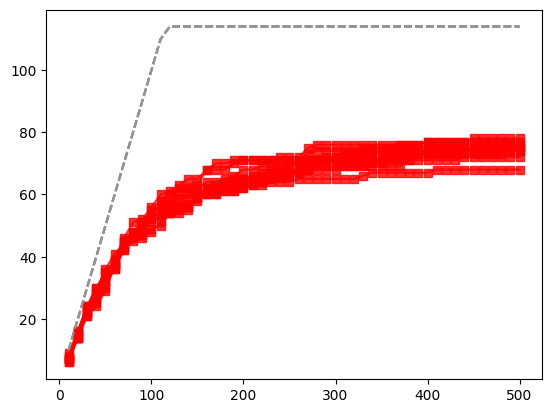

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm
import math

other_protein = "12ca5"
protein_of_interest = "MDM2"

model_types = [
    ("KNN", partial(KNeighborsRegressor, n_neighbors=5)),
    ("Random Forest", partial(RandomForestRegressor, n_estimators=200)),
    (
        "BiLSTM",
        partial(
            rnn.ThreeChannelRegressionRNN_gelu,
            depth=6,
            width=64,
            dropout=0.1,
            loss=multi_channel_mse,
        ),
    ),
]
values = [
    ("ER + FC", lambda x: x[1:]),
    ("ER", lambda x: [x[2]]),
    ("FC + P-val", lambda x: x[:2]),
    ("FC", lambda x: [x[1]]),
]

representations = [
    ("(One Hot)", [AA_REPRESENTATION.ONE_HOT]),
    (
        "(Physicochemical)",
        [
            AA_REPRESENTATION.PHYSIOCHEM_PROPERTIES,
            AA_REPRESENTATION.PRO2VEC,
            AA_REPRESENTATION.RAA,
        ],
    ),
    (
        "(Physicochemical + One Hot)",
        [
            AA_REPRESENTATION.PRO2VEC,
            AA_REPRESENTATION.RAA,
            AA_REPRESENTATION.PHYSIOCHEM_PROPERTIES,
            AA_REPRESENTATION.ONE_HOT,
        ],
    ),
]

columns = []
for model_type, _ in model_types:
    for rep_name, _ in representations:
        columns.append(model_type + " " + rep_name)
index = []
for value, _ in values:
    index.append(value)


save_file = f'{protein_of_interest}_model_comparisons.csv'
if os.path.exists(save_file):
    result_df = pd.read_csv(save_file, index_col=0)
else:
    result_df = pd.DataFrame(columns=columns, index=index, dtype=float)
    result_df.index.name = "Training Labels"


# Run the model comparisons

for rep_name, representation in tqdm(representations):
    for model_type, model in tqdm(model_types):
        for value, index_lambda in values:
            if not math.isnan(result_df.loc[value][model_type + " " + rep_name]):
                continue
            result = run_benchmark(
                model=model,
                other_protein=other_protein,
                protein_of_interest=protein_of_interest,
                aa_representations=representation,
                index_lambda=(value, index_lambda),
                cross_validation=True,
            )

            result_df.loc[value][model_type + " " + rep_name] = result
            result_df.to_csv(save_file)

/home/yitongt/ml_phage/src/preprocessing/y_representation.py:66: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(
/home/yitongt/ml_phage/src/preprocessing/y_representation.py:66: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(
/home/yitongt/ml_phage/src/preprocessing/y_representation.py:66: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(
/home/yitongt/ml_phage/src/preprocessing/y_representation.py:66: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs wh

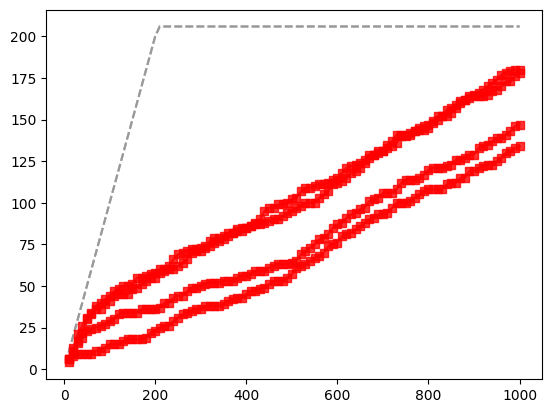

In [ ]:
# Add Raw Benchmark Values
result_df["Raw Experimental Values"] = [
    run_benchmark(
        protein_of_interest=protein_of_interest,
        other_protein=other_protein,
        index_lambda=tup,
        raw_benchmark=True,
    )
    for tup in values
]


<AxesSubplot:ylabel='Training Labels'>

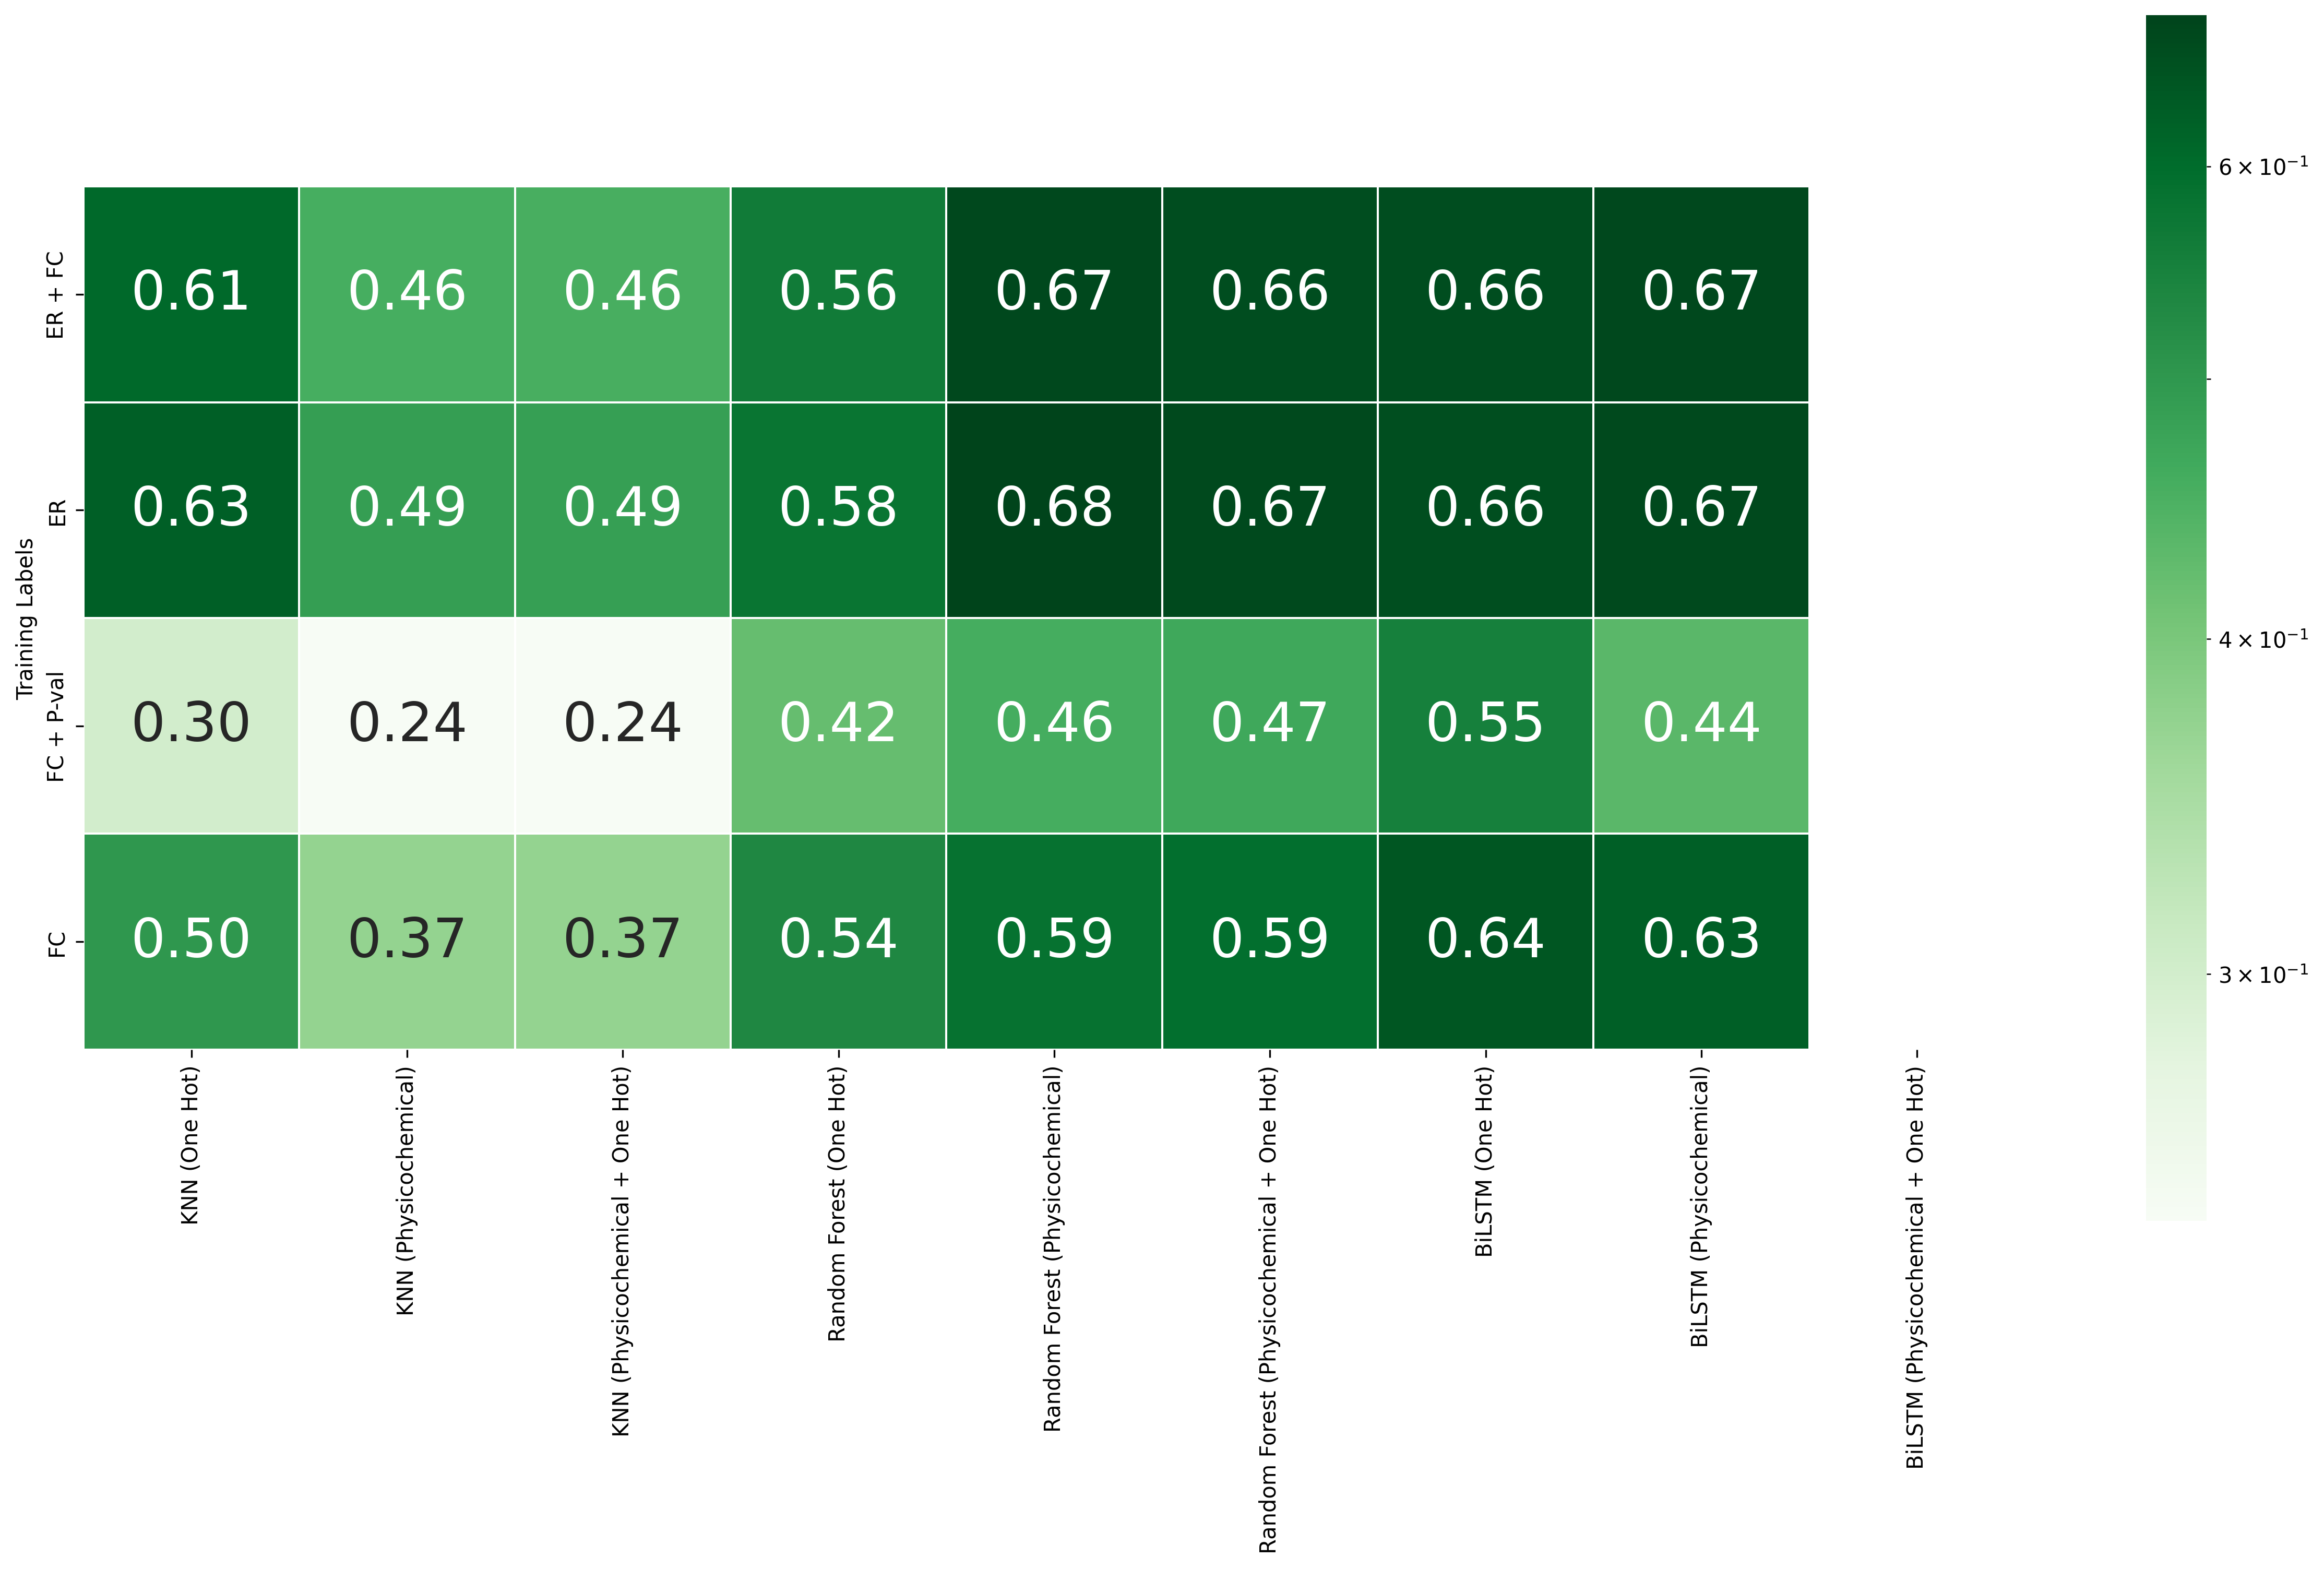

In [14]:
import seaborn as sns
from matplotlib.pyplot import figure
from matplotlib.colors import LogNorm

figure(figsize=(20, 10), dpi=300)
result_df[result_df.columns].astype(float)

sns.heatmap(result_df, annot=result_df, fmt=".2f", linewidths = .5, cmap="Greens", annot_kws={'size': 25}, square=True, norm=LogNorm()) # linewidths = .5, 